In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import tensorflow
import tqdm
import glob

from tqdm import tqdm

from skimage.io import imread, imshow
# from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_r = glob.glob('/content/drive/MyDrive/Waste_Control_Data/TRAIN/O/*.jpg')
a = len(train_r)
a

4863

In [4]:
train_r = glob.glob('/content/drive/MyDrive/Waste_Control_Data/TRAIN/R/*.jpg')
b= len(train_r)
b

4477

In [5]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory ='/content/drive/My Drive/Waste_Control_Data/TRAIN',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 128,
                                                   subset = 'training')

Found 7473 images belonging to 2 classes.


In [7]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/Waste_Control_Data/TRAIN',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 128,
                                                  subset = 'validation')

Found 1867 images belonging to 2 classes.


In [8]:
# Class Indices
train_dataset.class_indices

{'O': 0, 'R': 1}

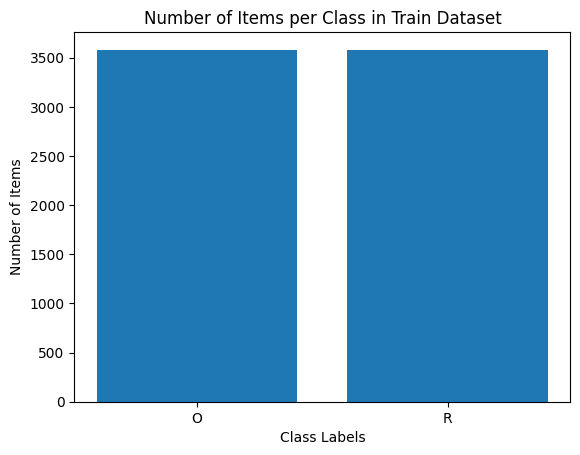

In [9]:
# Count the number of items for each label in the train dataset
train_labels_count = train_dataset.labels.sum(axis=0)

# Get the class labels
class_labels = train_dataset.class_indices.keys()

# Plot the bar graph
plt.bar(class_labels, train_labels_count)
plt.xlabel('Class Labels')
plt.ylabel('Number of Items')
plt.title('Number of Items per Class in Train Dataset')
plt.show()


In [10]:
from tensorflow.keras.applications import VGG19

# Load the VGG19 model with pre-trained weights
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


80134624/80134624 [==============================] - 0s 0us/step


In [11]:
#summary
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
# Defining Layers
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (Batch  (None, 25088)             100352    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                       

In [14]:
# Model Compile
OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

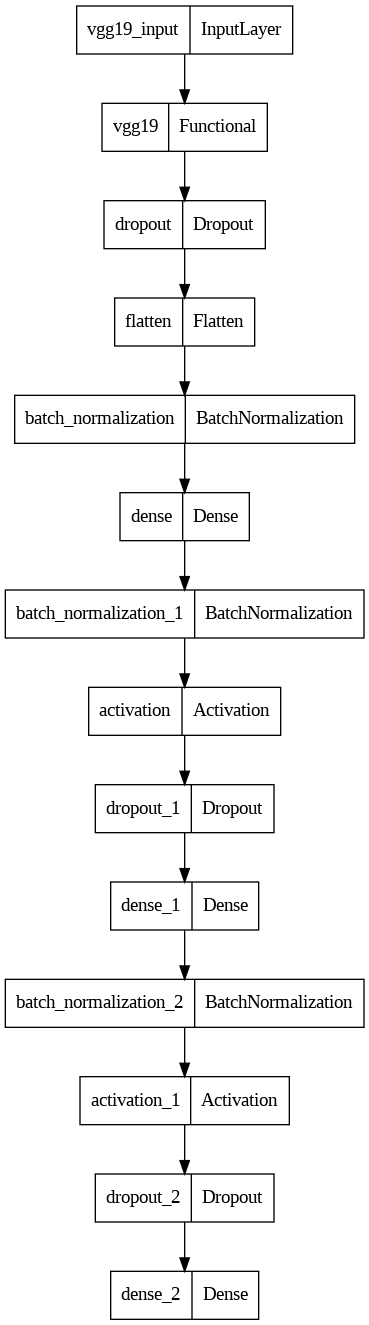

In [15]:
# Define Callbacks
filepath = './model_vgg19.h5'

earlystopping = EarlyStopping(monitor='val_auc',
                              mode='max',
                              patience=5,
                              verbose=1)

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_auc',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

callback_list = [earlystopping, checkpoint]

# Plot the model architecture
plot_model(model, to_file='model_vgg19.png')



In [16]:
# Model Training
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=15,
                    callbacks=callback_list,
                    verbose=1)



Epoch 1/15
59/59 [==============================] - ETA: 0s - loss: 0.3561 - auc: 0.9286 
Epoch 1: val_auc improved from -inf to 0.92168, saving model to ./model_vgg19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 1229s 20s/step - loss: 0.3561 - auc: 0.9286 - val_loss: 0.4370 - val_auc: 0.9217
Epoch 2/15
59/59 [==============================] - ETA: 0s - loss: 0.2456 - auc: 0.9636
Epoch 2: val_auc improved from 0.92168 to 0.92538, saving model to ./model_vgg19.h5
59/59 [==============================] - 141s 2s/step - loss: 0.2456 - auc: 0.9636 - val_loss: 0.3581 - val_auc: 0.9254
Epoch 3/15
59/59 [==============================] - ETA: 0s - loss: 0.2213 - auc: 0.9698
Epoch 3: val_auc improved from 0.92538 to 0.94596, saving model to ./model_vgg19.h5
59/59 [==============================] - 149s 3s/step - loss: 0.2213 - auc: 0.9698 - val_loss: 0.3011 - val_auc: 0.9460
Epoch 4/15
59/59 [==============================] - ETA: 0s - loss: 0.1973 - auc: 0.9762
Epoch 4: val_auc did not improve from 0.94596
59/59 [==============================] - 139s 2s/step - loss: 0.1973 - auc: 0.9762 - val_loss: 0.3356 - val_auc: 0.9448
Epoch 5/15
59/59 [===================

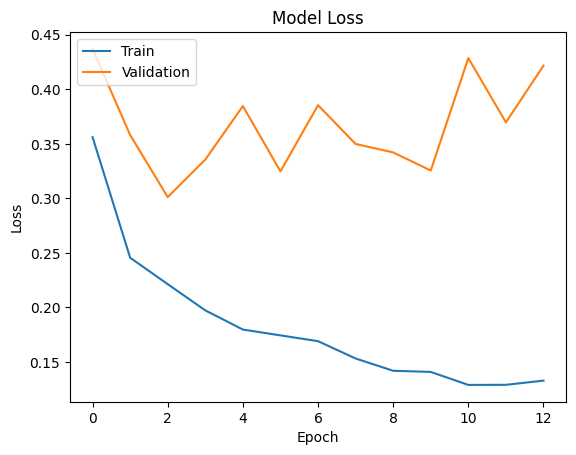

In [17]:
# Summarize model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


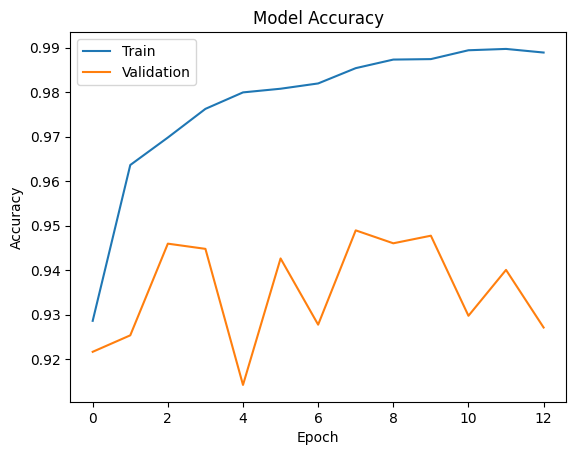

In [18]:
# Summarize model accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [19]:
# Test Data
test_data = test_datagen.flow_from_directory(directory='/content/drive/MyDrive/Waste_Control_Data/TEST',
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=128)


Found 1956 images belonging to 2 classes.


In [20]:
# evaluationg loss and Auc of test data
model.evaluate(test_data)

16/16 [==============================] - 256s 17s/step - loss: 0.6802 - auc: 0.8719


[0.6801607012748718, 0.8719303011894226]

1/1 [==============================] - 1s 1s/step
The image belongs to Organic waste category 


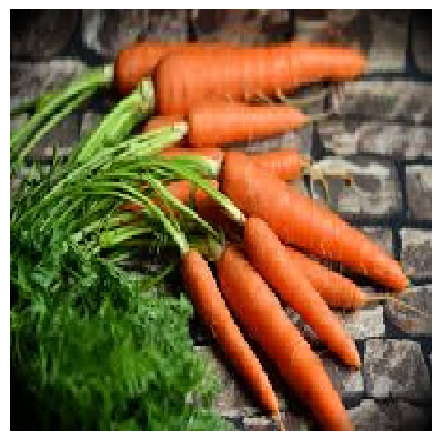

In [21]:
# Test Case:1 - ORGANIC
dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/Waste_Control_Data/TEST/O/O_12701.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

1/1 [==============================] - 0s 29ms/step
The image belongs to Organic waste category 


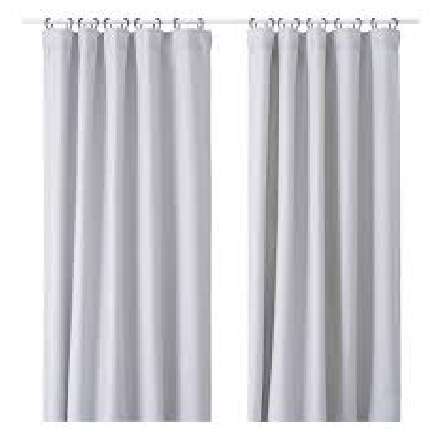

In [22]:
# Test Case:2 - RECYCLE

dic = test_data.class_indices
idc = {k:v for v,k in dic.items()}

img = load_img('/content/drive/MyDrive/Waste_Control_Data/TEST/R/R_10004.jpg', target_size=(224,224))
img = img_to_array(img)
img = img / 255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The image belongs to Recycle waste category")
else:
    print("The image belongs to Organic waste category ")

In [23]:
test_data.reset()  # Reset generator to start of dataset
y_true = test_data.classes
y_pred = model.predict(test_data)
# y_pred_classes = np.argmax(y_pred, axis=1)

16/16 [==============================] - 11s 711ms/step


In [24]:
binary_values = (y_pred >= 0.5).astype(int)


In [25]:
reshaped_array = binary_values.reshape(1956)
reshaped_array.shape


(1956,)

In [26]:
y_true.shape

(1956,)

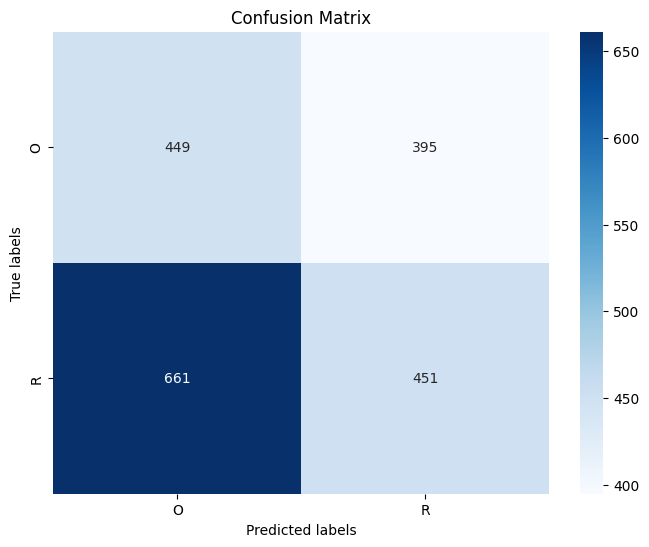

In [27]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, reshaped_array)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [28]:
binary_values_test = (y_pred >= 0.5).astype(int)

In [29]:
# Calculate Precision, Recall, F1 Score
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, binary_values_test, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.4776102169262332
Recall: 0.4601226993865031
F1 Score: 0.4601977699115219
